# DC2 Image Analysis, 511keV, Upsampling

updated on 2023-11-23 (the commit 59f2c7b74be6ee4228ede5ca8e2355c07589f3ba)

This notebook explains image reconstruction when the pixel resolution of the model map is set higher than the response matrix.

Note that this notebook is advanced. It is assumed that you have already performed the two notebooks (511keV-DC2-ScAtt-DataReduction.ipynb, 511keV-DC2-ScAtt-ImageDeconvolution.ipynb).

## Point

In the current implementation, the pixel size of the model map can be differnt from the that of the response. The model pixel size is used in the following instances:

- coordsys_conv_matrix
- image_deconvolution

Thus, make sure that NSIDE in these instances must be the same. In this notebook, I present the case with NSIDE = 32 in the model map.

If the NSIDE for the exposure table is not changed, you do not have to create the binned data.

There are three different NSIDE in priciple:

- NSIDE for the pixel resolution of the model (coordsys_conv_matrix, image_deconvolution)
- NSIDE for the pixel resolution of the response/data/background CDS (full_detector_response, inputs_511keV_DC2.yaml)
- NSIDE for the pixel resolution of the spacecraftattitude binning (exposure_table)

Usually, these three values can be set equal.

In [34]:
from histpy import Histogram, HealpixAxis, Axis, Axes
from mhealpy import HealpixMap
from astropy.coordinates import SkyCoord, cartesian_to_spherical, Galactic

from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.ts_map.TSMap import TSMap
from cosipy.data_io import UnBinnedData, BinnedData
from cosipy.image_deconvolution import SpacecraftAttitudeExposureTable, CoordsysConversionMatrix, DataLoader, ImageDeconvolution

# cosipy uses astropy units
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from scoords import Attitude, SpacecraftFrame

#3ML is needed for spectral modeling
from threeML import *
from astromodels import Band

#Other standard libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 

import healpy as hp
from tqdm.autonotebook import tqdm

In [10]:
nside_scatt_binning = 32
nside_model = 32

**In this notebook I change the NSIDE in the exposure table, so the binned data need to be reproduced.**

# 0. Prepare the data
Before running the cells, please download the files needed for this notebook. You can get them from wasabi. 

Actually, the data reduction is not optimized and takes hours depending on your environments. So I skip this process.
Please download the following data files and then run the following cells.

From wasabi
- cosi-pipeline-internal/COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5
- cosi-pipeline-public/COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori

From docs/tutorials/image_deconvolution/511keV
- inputs_511keV_DC2.yaml
- imagedeconvolution_parfile_scatt_511keV.yml

## Load the response and orientation files

<span style="color:red"> please modify "path_data" corresponding to your environment.</span>

In [3]:
path_data = "path/to/data/"

In [4]:
%%time

ori_filepath = path_data + "orientation/20280301_3_month.ori"
ori = SpacecraftFile.parse_from_file(ori_filepath)

CPU times: user 15.8 s, sys: 1.09 s, total: 16.9 s
Wall time: 16.6 s


In [5]:
full_detector_response_filename = path_data + "response/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"
full_detector_response = FullDetectorResponse.open(full_detector_response_filename)

nside_local = full_detector_response.nside
npix_local = hp.nside2npix(nside_local)

nside_local

16

In [6]:
full_detector_response

FILENAME: '/Users/yoneda/Work/Exp/COSI/cosipy-2/data_challenge/DC2/prework/data/response/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 3072
    NSIDE: 16
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 1
    EDGES: [509.0 keV, 513.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 1
    EDGES: [509.0 keV, 513.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 60
    EDGES: [0.0 deg, 3.0 deg, 6.0 deg, 9.0 deg, 12.0 deg, 15.0 deg, 18.0 deg, 21.0 deg, 24.0 deg, 27.0 deg, 30.0 deg, 33.0 deg, 36.0 deg, 39.0 deg, 42.0 deg, 45.0 deg, 48.0 deg, 51.0 deg, 54.0 deg, 57.0 deg, 60.0 deg, 63.0 deg, 66.0 deg, 69.0 deg, 72.0 deg, 75.0 deg, 78.0 deg, 81.0 deg, 84.0 deg, 87.0 deg, 90.0 deg, 93.0 

# 1. analyze the orientation file

This section is the same as in 511keV-DC2-ScAtt-DataReduction.ipynb, but the nisde is changed to 32.

In [7]:
%%time

exposure_table = SpacecraftAttitudeExposureTable.from_orientation(ori, nside = nside_scatt_binning, start = None, stop = None)
exposure_table

angular resolution:  1.8322594196359498 deg.



WARNING ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"



duration:  92.36059027777777 d



WARNING ErfaWarning: ERFA function "utctai" yielded 7979955 of "dubious year (Note 3)"



  0%|          | 0/7979955 [00:00<?, ?it/s]

CPU times: user 1min 12s, sys: 2.08 s, total: 1min 14s
Wall time: 1min 14s


,scatt_binning_index,healpix_index,zpointing,xpointing,zpointing_averaged,xpointing_averaged,delta_time,exposure,num_pointings,bkg_group
0,0,"(8272, 427)","[[44.62664815323754, -21.585226694584346], [44...","[[44.62664815323755, 68.41477330541565], [44.6...","[44.49705286596814, -21.370653963754705]","[44.49899938347305, 68.62948123249228]","[0.9999999999969589, 1.0000000000065512, 0.999...",22051.0,22051,0
1,1,"(8399, 427)","[[44.78167623289732, -21.840823005240516], [44...","[[44.781676232897325, 68.15917699475948], [44....","[44.84546317102121, -21.94574666279381]","[44.845668028631366, 68.05426833879696]","[0.9999999999969589, 0.9999999999969589, 0.999...",7207.0,7207,0
2,2,"(8528, 427)","[[44.937249783176014, -22.096275698920152], [4...","[[44.93724978317603, 67.90372430107985], [44.9...","[45.280789592422735, -22.65671255168847]","[45.28405398202019, 67.34354151639131]","[0.9999999999969589, 1.0000000000065512, 0.999...",29025.0,29025,0
3,3,"(8528, 488)","[[45.66020516346508, -23.269427365755966], [45...","[[45.6602051634651, 66.73057263424403], [45.69...","[45.792486557202956, -23.48162697469867]","[45.79313907872797, 66.51842748236865]","[1.0000000000065512, 0.9999999999969589, 0.999...",13091.0,13091,0
4,4,"(8656, 488)","[[45.978454945885545, -23.778456203550505], [4...","[[45.978454945885545, 66.22154379644951], [46....","[46.11600105920392, -23.997057178710705]","[46.11666483156788, 66.00300061062126]","[0.9999999999969589, 0.9999999999969589, 1.000...",13268.0,13268,0
...,...,...,...,...,...,...,...,...,...,...
562,562,"(3526, 515)","[[19.469949806943756, 24.43289490159796], [19....","[[199.46994980694376, 65.56710509840204], [199...","[19.471417500535573, 24.430350678106848]","[199.47141729115225, 65.56964934798671]","[1.000000000001755, 0.9999999999969589, 0.9999...",257.0,257,0
563,563,"(745, 3302)","[[289.1161733315789, 62.182064711183735], [289...","[[109.11617333157892, 27.817935288816265], [10...","[289.1158698854739, 62.181869345669945]","[109.11587008833249, 27.818130910219594]","[0.9999999999969589, 1.0000000000065512, 0.999...",216.0,216,0
564,564,"(11555, 3438)","[[129.37391657068838, -62.722167168565605], [1...","[[129.37391657068838, 27.277832831434402], [12...","[129.3748932372682, -62.7229126247577]","[129.3748932228599, 27.277087393995096]","[0.9999999999969589, 0.9999999999969589, 0.999...",38.0,38,0
565,565,"(749, 3438)","[[309.37452108662, 62.72183635479668], [309.37...","[[129.37452108662, 27.27816364520332], [129.37...","[309.3747190421793, 62.723149712157756]","[129.37471903379148, 27.27685031183828]","[0.9999999999969589, 1.0000000000065512, 1.000...",57.0,57,0


You can save SpacecraftAttitudeExposureTable as a fits file.

In [10]:
exposure_table.save_as_fits(f"exposure_table_nside{nside_scatt_binning}.fits", overwrite = True)

You can also read the fits file.

In [8]:
exposure_table_from_fits = SpacecraftAttitudeExposureTable.from_fits(f"exposure_table_nside{nside_scatt_binning}.fits")
exposure_table == exposure_table_from_fits

True

# 2. Calculate the coordinate conversion matrix


CoordsysConversionMatrix.spacecraft_attitude_binning_ccm can produce the coordinate conversion matrix for the spacecraft attitude binning.

In this calculation, the dwell time map is calculated for each model pixel and each scatt_binning_index.

If use_averaged_pointing is True, first the averaged Z- and X-pointings are calculated (the average of zpointing or xpointing in the exposure table), and then the dwell time map is calculated once for ach model pixel and each scatt_binning_index.

If use_averaged_pointing is False, the dwell time map is calculated for each attitude in zpointing and xpointing in the exposure table, and then the calculated dwell time maps are summed up. 

In the former case, the computation is fast but may lose the angular resolution. In the latter case, the conversion matrix is more accurate but it takes a long time to calculate it.

**With NSIDE = 32, this process may take a few hours. I also prepared a python script to create the conversion matrix. If the notebook does not work, you can use mk_ccm_upsampling.py**

In [ ]:
%%time

coordsys_conv_matrix = CoordsysConversionMatrix.spacecraft_attitude_binning_ccm(full_detector_response, exposure_table, nside_model = nside_model, use_averaged_pointing = True)

You can save CoordsysConversionMatrix as a hdf5 file.

In [18]:
coordsys_conv_matrix.write(f"ccm_nside{nside_model}.hdf5", overwrite = True)

You can also read the saved file.

In [17]:
coordsys_conv_matrix = CoordsysConversionMatrix.open(f"ccm_nside{nside_model}.hdf5")

**Check the matrix shape**

In [18]:
coordsys_conv_matrix.contents

Format,coo
Data Type,float64
Shape,"(12288, 567, 3072)"
nnz,27869184
Density,0.0013020833333333333
Read-only,True
Size,850.5M
Storage ratio,0.0


# 3. produce the binned data

In [21]:
def get_binned_data_scatt(unbinned_event, exposure_table, psichi_binning = 'local', sparse = False):
    exposure_dict = {row['healpix_index']: row['scatt_binning_index'] for _, row in exposure_table.iterrows()}
        
    # from BinnedData.py
 
    # Get energy bins:
    energy_bin_edges = np.array(unbinned_event.energy_bins)
    
    # Get phi bins:
    number_phi_bins = int(180./unbinned_event.phi_pix_size)
    phi_bin_edges = np.linspace(0,180,number_phi_bins+1)
    
    # Define psichi axis and data for binning:
    if psichi_binning == 'galactic':
        psichi_axis = HealpixAxis(nside = unbinned_event.nside, scheme = unbinned_event.scheme, coordsys = 'galactic', label='PsiChi')
        coords = SkyCoord(l=unbinned_event.cosi_dataset['Chi galactic']*u.deg, b=unbinned_event.cosi_dataset['Psi galactic']*u.deg, frame = 'galactic')
    if psichi_binning == 'local':
        psichi_axis = HealpixAxis(nside = unbinned_event.nside, scheme = unbinned_event.scheme, coordsys = SpacecraftFrame(), label='PsiChi')
        coords = SkyCoord(lon=unbinned_event.cosi_dataset['Chi local']*u.rad, lat=((np.pi/2.0) - unbinned_event.cosi_dataset['Psi local'])*u.rad, frame = SpacecraftFrame())

    # Define scatt axis and data for binning
    n_scatt_bins = len(exposure_table)
    scatt_axis = Axis(np.arange(n_scatt_bins + 1), label='ScAtt')
    
    is_nest = True if exposure_table.scheme == 'nested' else False
    
    nside_scatt = exposure_table.nside
    
    zindex = hp.ang2pix(nside_scatt, unbinned_event.cosi_dataset['Zpointings (glon,glat)'].T[0] * 180 / np.pi, 
                        unbinned_event.cosi_dataset['Zpointings (glon,glat)'].T[1] * 180 / np.pi, nest=is_nest, lonlat=True)
    xindex = hp.ang2pix(nside_scatt, unbinned_event.cosi_dataset['Xpointings (glon,glat)'].T[0] * 180 / np.pi, 
                        unbinned_event.cosi_dataset['Xpointings (glon,glat)'].T[1] * 180 / np.pi, nest=is_nest, lonlat=True)    
    scatt_data = np.array( [ exposure_dict[(z, x)] + 0.5 if (z,x) in exposure_dict.keys() else -1 for z, x in zip(zindex, xindex)] ) # should this "0.5" be needed?
    
    # Initialize histogram:
    binned_data = Histogram([scatt_axis,
                              Axis(energy_bin_edges*u.keV, label='Em'),
                              Axis(phi_bin_edges*u.deg, label='Phi'),
                              psichi_axis],
                              sparse=sparse)

    # Fill histogram:
    binned_data.fill(scatt_data, unbinned_event.cosi_dataset['Energies']*u.keV, np.rad2deg(unbinned_event.cosi_dataset['Phi'])*u.deg, coords)    
    
    return binned_data

In [22]:
%%time

signal_filepath = path_data + "source/511_thin_disk_3months.fits.gz"

unbinned_signal = UnBinnedData(input_yaml = "inputs_511keV_DC2.yaml")

unbinned_signal.cosi_dataset = unbinned_signal.get_dict_from_fits(signal_filepath)

binned_signal = get_binned_data_scatt(unbinned_signal, exposure_table, psichi_binning = 'local', sparse = False)

CPU times: user 5.11 s, sys: 300 ms, total: 5.41 s
Wall time: 5.41 s


In [23]:
%%time

bkg_filepath = path_data + "background/albedo_photons_3months_unbinned_data.fits.gz"

unbinned_bkg = UnBinnedData(input_yaml = "inputs_511keV_DC2.yaml")

unbinned_bkg.cosi_dataset = unbinned_bkg.get_dict_from_fits(bkg_filepath)

binned_bkg = get_binned_data_scatt(unbinned_bkg, exposure_table, psichi_binning = 'local', sparse = False)

CPU times: user 1min 33s, sys: 4.97 s, total: 1min 38s
Wall time: 1min 38s


In [24]:
binned_event = binned_signal + binned_bkg

# 4. Imaging deconvolution

## 4-1. Prepare DataLoader containing all neccesary datasets

In [25]:
dataloader = DataLoader.load(binned_event, 
                             binned_bkg, 
                             full_detector_response,
                             coordsys_conv_matrix,
                             is_miniDC2_format = False)

In [26]:
dataloader._modify_axes()

Note that this function is tentetive. It should be removed in the future!
Please run this function only once!
... checking the axis ScAtt of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Em of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Phi of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis PsiChi of the event and background files...
    --> pass (edges)
    --> pass (unit)
...checking the axis Em of the event and response files...
    --> pass (edges)
...checking the axis Phi of the event and response files...
    --> pass (edges)
...checking the axis PsiChi of the event and response files...
    --> pass (edges)
The axes in the event and background files are redefined. Now they are consistent with those of the response file.


## 4-2. Load the response file

In [27]:
%%time

dataloader.load_full_detector_response_on_memory()
dataloader.calc_image_response_projected() # mandatory

... (DataLoader) calculating a projected image response ...
CPU times: user 16.7 s, sys: 3.13 s, total: 19.8 s
Wall time: 20.6 s


## 4-3. Initialize the instance of the image deconvolution class

In [28]:
parameter_filepath = "imagedeconvolution_parfile_scatt_511keV.yml"

In [29]:
image_deconvolution = ImageDeconvolution()

# set dataloader to image_deconvolution
image_deconvolution.set_data(dataloader)

# set a parameter file for the image deconvolution
image_deconvolution.read_parameterfile(parameter_filepath)

data for image deconvolution was set ->  <cosipy.image_deconvolution.data_loader.DataLoader object at 0x471515720>
parameter file for image deconvolution was set ->  imagedeconvolution_parfile_scatt_511keV.yml


**Do not forget to make sure that NSIDE of the model map is modified**

In [30]:
image_deconvolution.override_parameter(f"model_property:nside = {nside_model}")

In [32]:
image_deconvolution.override_parameter("deconvolution:parameter_RL:iteration = 20")
image_deconvolution.override_parameter("deconvolution:parameter_RL:background_normalization_fitting = True")
image_deconvolution.override_parameter("deconvolution:parameter_RL:alpha_max = 10")
image_deconvolution.override_parameter("deconvolution:parameter_RL:smoothing_FWHM = 2.5")

image_deconvolution.initialize()

#### Initialization ####
1. generating a model map
---- parameters ----
coordinate: galactic
energy_edges:
- 509.0
- 513.0
nside: 32
scheme: ring

2. initializing the model map ...
---- parameters ----
algorithm: flat
parameter_flat:
  values:
  - 1e-4

3. resistering the deconvolution algorithm ...
... calculating the expected events with the initial model map ...
... calculating the response weighting filter...
... calculating the gaussian filter...


  0%|          | 0/12288 [00:00<?, ?it/s]

---- parameters ----
algorithm: RL
parameter_RL:
  acceleration: true
  alpha_max: 10
  background_normalization_fitting: true
  background_normalization_range:
  - 0.01
  - 10.0
  iteration: 20
  response_weighting: true
  response_weighting_index: 0.5
  save_results_each_iteration: false
  smoothing: true
  smoothing_FWHM: 2.5
  smoothing_max_sigma: 10.0

#### Done ####



## 4-5. Start the image deconvolution

In [33]:
%%time

all_results = image_deconvolution.run_deconvolution()

#### Deconvolution Starts ####


  0%|          | 0/20 [00:00<?, ?it/s]

  Iteration 1/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step



WARNING RuntimeWarning: invalid value encountered in divide



--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 2.4918880393981695
    loglikelihood: -1756598.0322312901
    background_normalization: 1.0024218882576656
  Iteration 2/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1711635.518049215
    background_normalization: 0.9971577453519401
  Iteration 3/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0871086083508263
    loglikelihood: -1701368.1536600601
    background_n

In [35]:
import pprint

pprint.pprint(all_results)

[{'alpha': <Quantity 2.49188804>,
  'background_normalization': 1.0024218882576656,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x42f3d6d40>,
  'iteration': 1,
  'loglikelihood': -1756598.0322312901,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x42f3d6e00>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x42f3d5f30>},
 {'alpha': 1.0,
  'background_normalization': 0.9971577453519401,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x4755268f0>,
  'iteration': 2,
  'loglikelihood': -1711635.518049215,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x475525900>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x42f3d6770>},
 {'alpha': <Quantity 1.08710861>,
  'background_normalization': 0.999685900356176,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x42f3d4b50>,
  'iteration': 3,
  'loglikelihood'

# 5. Analyze the results
Below examples to see/analyze the results are shown.

## Log-likelihood

Plotting the log-likelihood vs the number of iterations

Text(0, 0.5, 'loglikelihood')

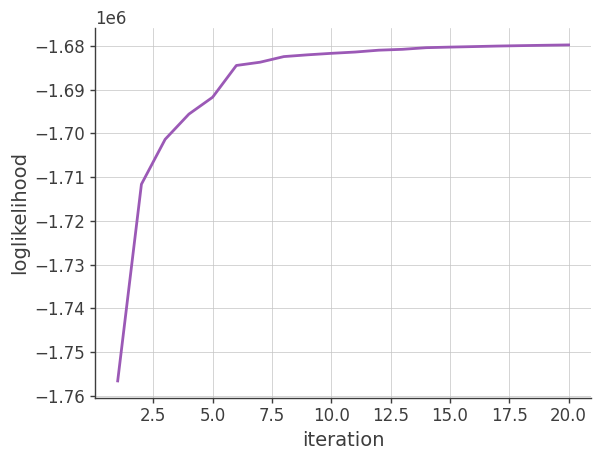

In [36]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['loglikelihood'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("loglikelihood")

## Alpha (the factor used for the acceleration)

Plotting $\alpha$ vs the number of iterations. $\alpha$ is a parameter to accelerate the EM algorithm (see the beginning of Section 4). If it is too large, reconstructed images may have artifacts.

Text(0, 0.5, 'alpha')

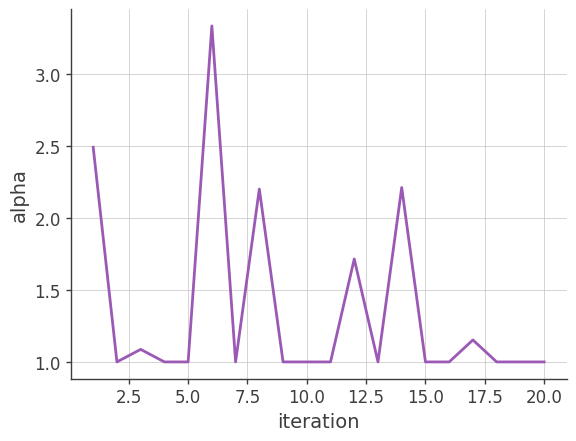

In [37]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['alpha'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("alpha")

## Background normalization

Plotting the background nomalization factor vs the number of iterations. If the backgroud model is accurate and the image is reconstructed perfectly, this factor should be close to 1.

Text(0, 0.5, 'background_normalization')

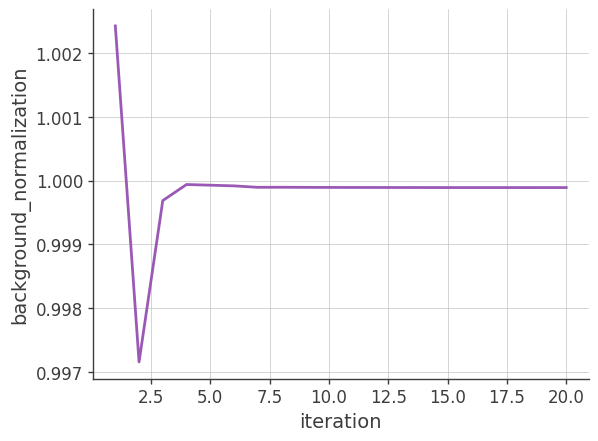

In [38]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['background_normalization'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("background_normalization")

## The reconstructed images

In [39]:
def plot_reconstructed_image(result, source_position = None): # source_position should be (l,b) in degrees
    iteration = result['iteration']
    image = result['model_map']

    for energy_index in range(image.axes['Ei'].nbins):
        map_healpxmap = HealpixMap(data = image[:,energy_index], unit = image.unit)

        _, ax = map_healpxmap.plot('mollview')        
        
        _.colorbar.set_label(str(image.unit))
        
        if source_position is not None:
            ax.scatter(source_position[0]*u.deg, source_position[1]*u.deg, transform=ax.get_transform('world'), color = 'red')

        plt.title(label = f"iteration = {iteration}, energy_index = {energy_index} ({image.axes['Ei'].bounds[energy_index][0]}-{image.axes['Ei'].bounds[energy_index][1]})")

Plotting the reconstructed images in all of the energy bands at the 20th iteration

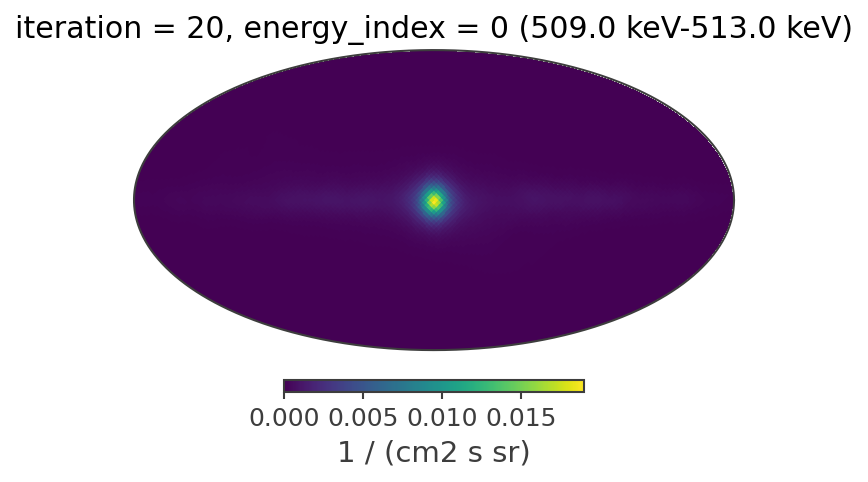

In [41]:
iteration = 19

plot_reconstructed_image(all_results[iteration])

An example to plot the image in the log scale

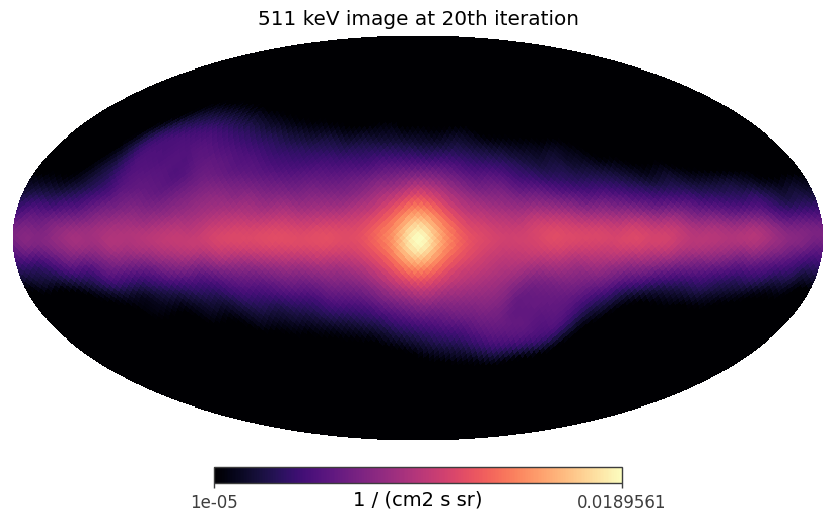

In [51]:
iteration_idx = 19

result = all_results[iteration_idx]

iteration = result['iteration']
image = result['model_map']

data = image[:,0]
data[data <= 0 * data.unit] = 1e-12 * data.unit

hp.mollview(data, min = 1e-5, norm ='log', unit = str(data.unit), title = f'511 keV image at {iteration}th iteration', cmap = 'magma')

plt.show()